# MachineLearningWorkShop at UCSC
## Aug 18th - Learning with TESS Simulated data

### Last month we explored all type of learning algorithms with simulated light curves including:
- different planet sizes
- various period
- various white/red noise level
- different baseline

While the result looked promising, we need to extend our experiments to more realistic data. 

The data set we are using today is created from **SPyFFI**, an image simulator created by Zack Berta and his undergrad student Jacobi Kosiarok. 

The ingrediants included by **SPyFFI** are:
- catalogs of real stars
- somewhat realistic Camera and CCD effects, such as PRF variation, readout smear, resembling the TESS telescope
- spacecraft effects such as jitter/focusing change
- somewhat realistic noise buget
- transits and stellar variability (sine curves) draw from Kepler

**SPyFFI** out puts image time series like this:
![alt text](ds9.jpeg)

We process the images from 10 days of TESS observations with standard photometry pipeline, and create light curves for all the stars with TESS magnituded brighter than 14. 

For the region of sky we simulated (6 by 6 square degree), this results in 16279 stars. To make our tasks today simpler, we are going to work with only ~4000 stars.  

In [115]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [133]:
def collect_lc_feature(idlist):
    LCfeature=np.zeros([len(idlist),481])
    count=0
    for i in idlist:
        #print i
        infile="LTFsmall/"+str(i)+".ltf"
        lc=np.loadtxt(infile)[:,1]
        LCfeature[count,0]=i
        LCfeature[count,1:]=lc
        count+=1
    return LCfeature
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['false positives', 'transits'], rotation=45)
    plt.yticks(tick_marks, ['false positives', 'transits'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def fit(model,name,data,cv=True):
    trainX,trainY,testX,testY,X,Y=data
    model.fit(trainX, trainY)
    predY = model.predict(testX)
    score = metrics.f1_score(testY, predY)
    
    print "#####################################"
    print "Result using",model
    print "f1 score from train test split %f" % score
    if cv:
        cvscore= cross_val_score(model, X, Y, cv = 5, scoring = 'f1')
        print "f1 score from CV5 %f" % np.mean(cvscore)
    cm = metrics.confusion_matrix(testY, predY)
    plot_confusion_matrix(cm)
    
    print cm
    #make_ROC_curve(testY,predY,name)
    return

Let's first look at what the TESS light curves: 

TESS_simulated_10day_small.csv is the combined feature file.

TESS_simulated_lc_small.csv is the light curve file.

In [134]:
df=pd.read_csv("TESS_simulated_10day_small.csv",index_col=0)

In [135]:
#LCfeature=pd.DataFrame(collect_lc_feature(df['Ids']),columns=['Ids']+list(np.arange(480)))
LCfeature.to_csv
#LCfeature=pd.read_csv("TESS_simulated_lc_small.csv",index_col=0)

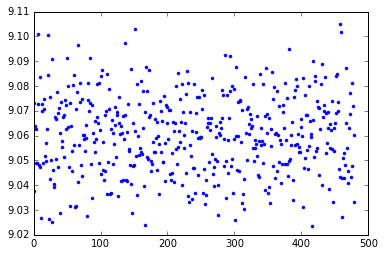

In [120]:
plt.plot(LCfeature.iloc[-1,1:],'.')

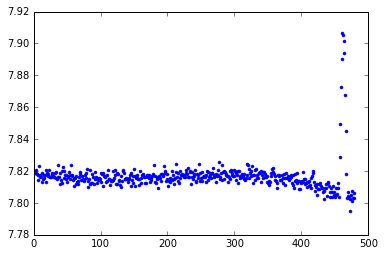

In [121]:
plt.plot(LCfeature.iloc[0,:],'.')

The combined feature files contain features from Box Least Squal measurements, and 20 PCA components from the light curve. Later on hopefully we can explore how to create new features from the light curves.

Let's first examine the columns in the combined feature files: 

In [122]:
df.columns

Index([u'BLS_Period_1_0', u'BLS_Tc_1_0', u'BLS_SN_1_0', u'BLS_SR_1_0',
       u'BLS_SDE_1_0', u'BLS_Depth_1_0', u'BLS_Qtran_1_0', u'BLS_Qingress_1_0',
       u'BLS_OOTmag_1_0', u'BLS_i1_1_0', u'BLS_i2_1_0', u'BLS_deltaChi2_1_0',
       u'BLS_fraconenight_1_0', u'BLS_Npointsintransit_1_0',
       u'BLS_Ntransits_1_0', u'BLS_Npointsbeforetransit_1_0',
       u'BLS_Npointsaftertransit_1_0', u'BLS_Rednoise_1_0',
       u'BLS_Whitenoise_1_0', u'BLS_SignaltoPinknoise_1_0', u'Ids', u'Depth',
       u'Catalog_Period', u'Catalog_Epoch', u'SNR', u'CatalogY', u'ManuleY',
       u'CombinedY', u'P0', u'P1', u'P2', u'P3', u'P4', u'P5', u'P6', u'P7',
       u'P8', u'P9', u'P10', u'P11', u'P12', u'P13', u'P14', u'P15', u'P16',
       u'P17', u'P18', u'P19'],
      dtype='object')

Columns **Ids**, **Catalog_Period**, **Depth**, **Catalog_Epoch** records the information we have regarding the injected transits. Anything with period smaller than 0 is not a transit. 

**SNR** is the signal to noise calculated for the transits using the catalog value. 

SNR=\sqrt{Ntransit}*Depth/200mmag

There are three type of Y values included in this feature file:

-**CatalogY** marks **True** for all the transit planets with **SNR** larger than 8.5 and **BLS_SignaltoPinkNoise_1_0** larger than 7. 

-**ManuleY** marks **True** all the transits identified by eye. 

-**CombinedY** marks **True** if either **CatalogY** and **ManuleY** is True. 

The signals identified by manule effort but not by Catalog is due to blending. The signal missed by manule effort is either because of low signal to noise or due to cuts in Ntransit and Q value (standard practice before manuel inspection). 

Let's drop the irrelevent columns before training:

In [123]:
X=df.drop(['Ids','CatalogY','ManuleY','CombinedY','Catalog_Period','Depth','Catalog_Epoch','SNR'],axis=1)
#print X.isnull().any()

In [124]:
Y=df['CombinedY']

In [125]:
trainX, testX, trainY, testY= train_test_split(X, Y,test_size = 0.2)
data=[trainX,trainY,testX,testY,X,Y]

We show the results from some standard algorithms here: 

#####################################
Result using RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
f1 score from train test split 0.846154
[[769   3]
 [  9  33]]


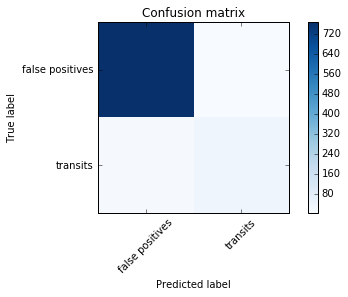

In [127]:
model=RandomForestClassifier(n_estimators=1000,n_jobs=-1)
name="RFC"
fit(model,name,data,cv=False)

#####################################
Result using GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
f1 score from train test split 0.846154
[[769   3]
 [  9  33]]


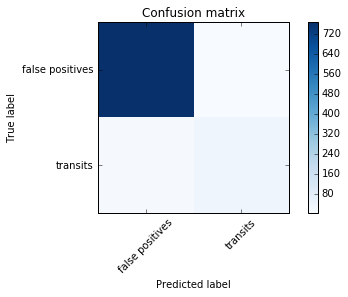

In [128]:
model=GradientBoostingClassifier(n_estimators=1000)
name="GBC"
fit(model,name,data,cv=False)

#####################################
Result using XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
f1 score from train test split 0.779221
[[767   5]
 [ 12  30]]


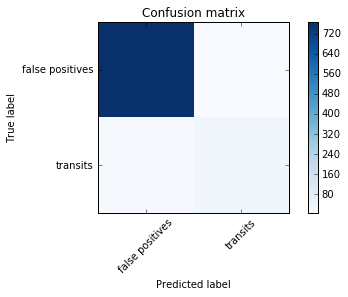

In [131]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=1000)
model.fit(trainX,trainY)
#model.plot_importance(bst)
#name="XGBoost"
fit(model,name,data,cv=False)

We can compare the prediction with the Manuel selection and the Catalog selection as the following: 

In [132]:
from sklearn.cross_validation import StratifiedKFold

model=RandomForestClassifier(n_estimators=3000,n_jobs=-1,class_weight='balanced_subsample')

skf=StratifiedKFold(Y,n_folds=5)
i=1
for train_index,test_index in skf:
    trainX=X.iloc[train_index];testX=X.iloc[test_index]
    trainY=np.array(Y)[train_index];testY=np.array(Y)[test_index]
    #print train_index
    traincatY=np.array(df['CatalogY'])[train_index];testcatY=np.array(df['CatalogY'])[test_index]
    trainmanY=np.array(df['ManuleY'])[train_index];testmanY=np.array(df['ManuleY'])[test_index]
    model.fit(trainX,trainY)
    predY=model.predict(testX)
    
    
    flag1=(predY==1)*(predY==np.array(testY))

    flag2=(predY==1)*(predY==np.array(testmanY))
    print "fold %d:" % i
    print "predict Transit %d" % len(predY[predY==1])
    print "real Transit %d" % len(testY[testY==1])
    print "real Transit selected by eye %d" % len(testmanY[testmanY==1])
    print "predicted Transit that's real %d" % len(predY[flag1])
    print "predicted Transits selected by eye %d" % len(predY[flag2])
    i+=1

fold 1:
predict Transit 41
real Transit 41
real Transit selected by eye 21
predicted Transit that's real 37
predicted Transits selected by eye 19
fold 2:
predict Transit 36
real Transit 41
real Transit selected by eye 19
predicted Transit that's real 33
predicted Transits selected by eye 17
fold 3:
predict Transit 40
real Transit 41
real Transit selected by eye 21
predicted Transit that's real 35
predicted Transits selected by eye 18
fold 4:
predict Transit 33
real Transit 40
real Transit selected by eye 17
predicted Transit that's real 28
predicted Transits selected by eye 13
fold 5:
predict Transit 35
real Transit 40
real Transit selected by eye 24
predicted Transit that's real 28
predicted Transits selected by eye 18


### Feature Selection

In [60]:
featurelist=X.columns
rfc= RandomForestClassifier(n_estimators=1000)
rfc.fit(trainX, trainY)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [61]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
threshold=0.02
droplist=[]
for f in range(X.shape[1]):
    if importances[indices[f]]<threshold:
        droplist.append(featurelist[indices[f]])
    print("%d. feature %d (%s %f)" % (f + 1, indices[f], featurelist[indices[f]],importances[indices[f]]))

Feature ranking:
1. feature 11 (BLS_deltaChi2_1_0 0.177686)
2. feature 2 (BLS_SN_1_0 0.149139)
3. feature 19 (BLS_SignaltoPinknoise_1_0 0.146289)
4. feature 3 (BLS_SR_1_0 0.051140)
5. feature 12 (BLS_fraconenight_1_0 0.041260)
6. feature 5 (BLS_Depth_1_0 0.039411)
7. feature 4 (BLS_SDE_1_0 0.035098)
8. feature 13 (BLS_Npointsintransit_1_0 0.030082)
9. feature 6 (BLS_Qtran_1_0 0.029436)
10. feature 16 (BLS_Npointsaftertransit_1_0 0.025583)
11. feature 7 (BLS_Qingress_1_0 0.023025)
12. feature 15 (BLS_Npointsbeforetransit_1_0 0.017720)
13. feature 18 (BLS_Whitenoise_1_0 0.012853)
14. feature 1 (BLS_Tc_1_0 0.011682)
15. feature 0 (BLS_Period_1_0 0.011579)
16. feature 8 (BLS_OOTmag_1_0 0.010918)
17. feature 20 (P0 0.010861)
18. feature 14 (BLS_Ntransits_1_0 0.010812)
19. feature 37 (P17 0.009331)
20. feature 9 (BLS_i1_1_0 0.009149)
21. feature 23 (P3 0.008815)
22. feature 27 (P7 0.008669)
23. feature 39 (P19 0.008580)
24. feature 26 (P6 0.008536)
25. feature 22 (P2 0.008022)
26. feature 25

In [62]:
X_selected=X.drop(droplist,axis=1)
X_selected.head()

,BLS_SN_1_0,BLS_SR_1_0,BLS_SDE_1_0,BLS_Depth_1_0,BLS_Qtran_1_0,BLS_Qingress_1_0,BLS_deltaChi2_1_0,BLS_fraconenight_1_0,BLS_Npointsintransit_1_0,BLS_Npointsaftertransit_1_0,BLS_SignaltoPinknoise_1_0
541,2.49988,0.00688,2.49988,0.04479,0.03663,0.29572,-185.70846,0.99805,19.0,20.0,13.86700
604,4.39096,0.00347,4.64008,0.05524,0.01054,0.26842,-28.23808,0.41000,6.0,6.0,10.97904
702,3.29002,0.00713,3.20909,0.10175,0.01909,0.45928,-176.90254,1.00000,7.0,8.0,32.06993
877,6.85637,0.02010,4.92262,0.07588,0.13405,0.27883,-353.58304,0.11346,65.0,65.0,109.17561
921,3.56150,0.00390,3.49625,0.05504,0.01635,0.41483,-184.19155,1.00000,6.0,6.0,33.67623


#####################################
Result using RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
f1 score from train test split 0.864865
f1 score from CV5 0.837376
[[772   6]
 [  4  32]]


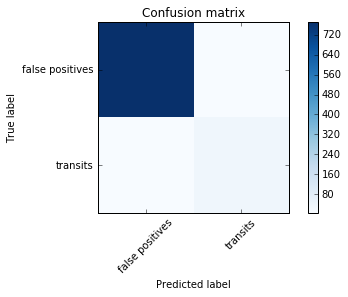

In [63]:
model=RandomForestClassifier(n_estimators=1000,n_jobs=-1,class_weight='balanced_subsample')
name="RFC"
fit(model,name,data)

## Tasks for Today: 
- optimize the models.
- lower the threshold of what is True in combinedY, and determine a limit of 0.7 f1 score.
- feature engerneering with unsupervised learning using the LC files. 
- More feature selection. 
- Try the larger data set if interested. 